The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [1]:
!pip install d2l==0.14.4


     |████████████████████████████████| 61kB 1.9MB/s 


# Concise Implementation of Recurrent Neural Networks

While :numref:`sec_rnn_scratch` was instructive to see how RNNs are implemented,
this is not convenient or fast.
This section will show how to implement the same language model more efficiently
using functions provided by high-level APIs
of a deep learning framework.
We begin as before by reading the time machine dataset.


In [2]:
from d2l import torch as d2l
import torch
from torch import nn
from torch.nn import functional as F

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

## Defining the Model

High-level APIs provide implementations of recurrent neural networks.
We construct the recurrent neural network layer `rnn_layer` with a single hidden layer and 256 hidden units.
In fact, we have not even discussed yet what it means to have multiple layers---this will happen in :numref:`sec_deep_rnn`.
For now, suffice it to say that multiple layers simply amount to the output of one layer of RNN being used as the input for the next layer of RNN.


In [3]:
num_hiddens = 256
rnn_layer = nn.RNN(len(vocab), num_hiddens)

We use a tensor to initialize the hidden state,
whose shape is
(number of hidden layers, batch size, number of hidden units).


In [4]:
state = torch.zeros((1, batch_size, num_hiddens))
state.shape

torch.Size([1, 32, 256])

With a hidden state and an input,
we can compute the output with
the updated hidden state.
It should be emphasized that
the "output" (`Y`) of `rnn_layer`
does *not* involve computation of output layers:
it refers to 
the hidden state at *each* time step,
and they can be used as the input
to the subsequent output layer.


In [5]:
X = torch.rand(size=(num_steps, batch_size, len(vocab)))
Y, state_new = rnn_layer(X, state)
Y.shape, state_new.shape

(torch.Size([35, 32, 256]), torch.Size([1, 32, 256]))

Similar to :numref:`sec_rnn_scratch`,
we define an `RNNModel` class 
for a complete RNN model.
Note that `rnn_layer` only contains the hidden recurrent layers, we need to create a separate output layer.


In [6]:
#@save
class RNNModel(nn.Module):
    """The RNN model."""
    def __init__(self, rnn_layer, vocab_size, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        self.num_hiddens = self.rnn.hidden_size
        # If the RNN is bidirectional (to be introduced later),
        # `num_directions` should be 2, else it should be 1.
        if not self.rnn.bidirectional:
            self.num_directions = 1
            self.linear = nn.Linear(self.num_hiddens, self.vocab_size)
        else:
            self.num_directions = 2
            self.linear = nn.Linear(self.num_hiddens * 2, self.vocab_size)

    def forward(self, inputs, state):
        X = F.one_hot(inputs.T.long(), self.vocab_size)
        X = X.to(torch.float32)
        Y, state = self.rnn(X, state)
        # The fully connected layer will first change the shape of `Y` to
        # (`num_steps` * `batch_size`, `num_hiddens`). Its output shape is
        # (`num_steps` * `batch_size`, `vocab_size`).
        output = self.linear(Y.reshape((-1, Y.shape[-1])))
        return output, state

    def begin_state(self, device, batch_size=1):
        if not isinstance(self.rnn, nn.LSTM):
            # `nn.GRU` takes a tensor as hidden state
            return  torch.zeros((self.num_directions * self.rnn.num_layers,
                                 batch_size, self.num_hiddens), 
                                device=device)
        else:
            # `nn.LSTM` takes a tuple of hidden states
            return (torch.zeros((
                self.num_directions * self.rnn.num_layers,
                batch_size, self.num_hiddens), device=device),
                    torch.zeros((
                        self.num_directions * self.rnn.num_layers,
                        batch_size, self.num_hiddens), device=device))

## Training and Predicting

Before training the model, let us make a prediction with the a model that has random weights.


In [7]:
device = d2l.try_gpu()
model = RNNModel(rnn_layer, vocab_size=len(vocab))
model = model.to(device)
d2l.predict_ch8('time traveller', 10, model, vocab, device)

'time travellerhwwhwwwwhw'

As is quite obvious, this model does not work at all. Next, we call `train_ch8` with the same hyperparameters defined in :numref:`sec_rnn_scratch` and train our model with high-level APIs.


perplexity 1.3, 262365.4 tokens/sec on cuda:0
time traveller held in his hand was a glitteringmetallic framewo
traveller for shade west in fouth manieg in theere thing in


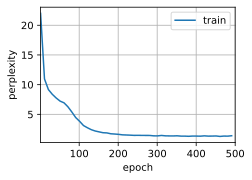

In [8]:
num_epochs, lr = 500, 1
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

Compared with the last section, this model achieves comparable perplexity,
albeit within a shorter period of time, due to the code being more optimized by
high-level APIs of the deep learning framework.


## Summary

* High-level APIs of the deep learning framework provides an implementation of the RNN layer.
* The RNN layer of high-level APIs returns an output and an updated hidden state, where the output does not involve output layer computation.
* Using high-level APIs leads to faster RNN training than using its implementation from scratch.

## Exercises

1. Can you make the RNN model overfit using the high-level APIs?
1. What happens if you increase the number of hidden layers in the RNN model? Can you make the model work?
1. Implement the autoregressive model of :numref:`sec_sequence` using an RNN.


[Discussions](https://discuss.d2l.ai/t/1053)
